# K-fold cross-validation
In k-fold cross-validation the dataset is split in K parts: k-1 parts are used during training and the remaining part is used for testing the generalization capabilities of the model. This method has the advantage of giving more consistent results than hold-out validation. In this notebook you are going to explore the behaviour of k-fold cross-validation by simulating datasets with diverse degrees of complexity.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets

%matplotlib inline

## The dataset
This function creates a dataset with two classes in two dimensions. It has two parameters: the size of the dataset and the spread of each one of the classes. A high spread value makes both classes to superpose, making the classification more difficult.

In [2]:
def create_dataset(n, s):
    n1 = int(np.ceil(n / 2.0))
    n2 = int(np.floor(n / 2.0))
    x1 = np.random.normal(-1, s, n1)
    y1 = np.random.uniform(-1, 1,  n1)
    x2 = np.random.normal(1, s, n2)
    y2 = np.random.uniform(-1, 1, n2)
    return np.stack((np.concatenate((x1, x2)), np.concatenate((y1, y2)), np.concatenate((np.ones(n1), -1*np.ones(n2)))), 1)

In [5]:
def plot_dataset(s):
    dataset = create_dataset(200, s)
    pl.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'r'])[int(cl > 0)] for cl in dataset[:,2]])
    pl.xlim(-3,3)
    pl.ylim(-1,1)
    pl.grid()

In [6]:
interact(plot_dataset, s=widgets.FloatSlider(value=0.1, min=0.1, max=1.0, step=0.01, description='Spread:',));

interactive(children=(FloatSlider(value=0.1, description='Spread:', max=1.0, min=0.1, step=0.01), Output()), _dom_classes=('widget-interact',))

## The MLP

In [7]:
import mlp_backprop_momentum as mlp

## Exploring k-fold cross-validation
The following function splits the dataset in K parts.

In [8]:
def split_dataset(dataset, n_parts=5):
    n_rows = dataset.shape[0]
    index_all = np.arange(n_rows)
    np.random.shuffle(index_all)
    parts = []
    current_start = 0
    for p in np.arange(n_parts):
        current_end = current_start + int(np.floor(n_rows / (n_parts-p)))
        parts.append(dataset[index_all[current_start:current_end],:])
        n_rows -= current_end - current_start
        current_start = current_end
    return parts

In [9]:
def k_fold_cross_validation(mlp, dataset, K=5, learning_rate=0.01, momentum=0.7, epochs=100):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = split_dataset(dataset, K)
    
    for k in np.arange(K):
        mlp.init_weights()
        
        training_parts = set(np.arange(K))
        training_parts.remove(k)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k]

        input_data = dataset_train[:,0:nn.n_inputs]
        output_data = dataset_train[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        input_data_test = dataset_test[:,0:nn.n_inputs]
        output_data_test = dataset_test[:,nn.n_inputs:(nn.n_inputs+nn.n_outputs)]
        
        MSE_train = mlp.fit((input_data, output_data),
                            learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        temp, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += temp
        temp, _ = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += temp

    return (MSE_train_mean / K, MSE_test_mean / K)

### Experiment
In this experiment we create datasets with different degrees of complexity and we test the behaviour of k-fold cross-validation with each one of them. For each dataset, we split the dataset several times, which generates different partitions training/testing.

In [10]:
N_SPLITS = 10
DATASET_SIZE = 200
EPOCHS = 20
N_NEURONS = 2
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.7
DATA_PARAMS = np.arange(0.4, 0.71, 0.1)

In [11]:
MSE_train = np.zeros((len(DATA_PARAMS), N_SPLITS))
MSE_test = np.zeros((len(DATA_PARAMS), N_SPLITS))
nn = mlp.MLP([2,N_NEURONS,1], 'tanh')

for p, s in enumerate(DATA_PARAMS):                                     # looping the set of parameters
    print('Testing dataset with variance:', s)

    dataset = create_dataset(DATASET_SIZE, s)

    for d in np.arange(N_SPLITS):                                       # looping the splits
        sys.stdout.write('.')

        temp1, temp2 = k_fold_cross_validation(nn,
                                               dataset,
                                               K=K,
                                               learning_rate=LEARNING_RATE,
                                               momentum=MOMENTUM,
                                               epochs=EPOCHS)
        MSE_train[p,d] = temp1
        MSE_test[p,d] = temp2
    print(N_SPLITS, ' tests done')

Testing dataset with variance: 0.4
..........10  tests done
Testing dataset with variance: 0.5
..........10  tests done
Testing dataset with variance: 0.6
..........10  tests done
Testing dataset with variance: 0.7
..........10  tests done


Plotting the resulting MSE, we can observe that each partition, i.e., each run of cross-validation, generates values of model error which are closer than the results found when using hold-out validation.

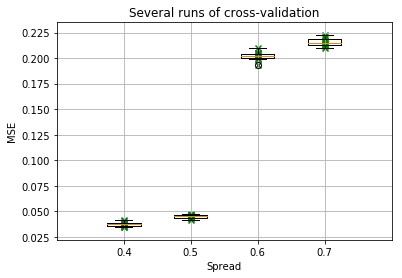

In [12]:
pl.boxplot(MSE_test.T, positions=DATA_PARAMS, widths=0.05)
for c in np.arange(MSE_test.shape[1]):
    pl.scatter(DATA_PARAMS, MSE_test[:,c], c='g', marker='x')
pl.xlim(np.min(DATA_PARAMS)-0.1, np.max(DATA_PARAMS)+0.1)
pl.xlabel('Spread')
pl.ylabel('MSE')
pl.title('Several runs of cross-validation')
pl.grid()